In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import itertools
from adjustText import adjust_text
import json

# Main plot

In [2]:
rsa = pd.read_csv('../../data/final/rsa.csv')
rsa

,name_i,name_j,spearman,n_words
0,CBOW_GoogleNews,fastText_CommonCrawl,0.633686,42374
1,CBOW_GoogleNews,fastText_Wiki_News,0.540727,41950
2,CBOW_GoogleNews,fastTextSub_OpenSub,0.461847,39759
3,CBOW_GoogleNews,GloVe_CommonCrawl,0.499414,42352
4,CBOW_GoogleNews,GloVe_Twitter,0.220378,32417
...,...,...,...,...
295,EEG_text,fMRI_text_hyper_align,0.194555,537
296,EEG_text,microarray,0.115807,266
297,fMRI_speech_hyper_align,fMRI_text_hyper_align,0.208698,315
298,fMRI_speech_hyper_align,microarray,0.048022,138


In [3]:
with open('../../data/raw/embed_to_dtype.json', 'r') as f:
    dtype_to_embed = json.load(f)
    
rsa['dtype_i'] = rsa['name_i'].map(dtype_to_embed)
rsa['dtype_j'] = rsa['name_j'].map(dtype_to_embed)

# Text clustering
text_text = rsa.query('dtype_i == "text" & dtype_j == "text"')['spearman'].mean().round(2)
print(f'Within-text mean correlation {text_text}')
text_other = rsa.query('(dtype_i == "text" & dtype_j != "text") | (dtype_i != "text" & dtype_j == "text")')['spearman'].mean().round(2)
print(f'Text-other mean correlation {text_other}')
print('---------------')

# Brain clustering
brain_brain = rsa.query('dtype_i == "brain" & dtype_j == "brain"')['spearman'].mean().round(2)
print(f'Within-brain mean correlation {brain_brain}')
brain_other = rsa.query('(dtype_i == "brain" & dtype_j != "brain") | (dtype_i != "brain" & dtype_j == "brain")')['spearman'].mean().round(2)
print(f'Brain-other mean correlation {brain_other}')
print('---------------')

# Behavior clustering
behavior_behavior = rsa.query('dtype_i == "behavior" & dtype_j == "behavior"')['spearman'].mean().round(2)
print(f'Within-behavior mean correlation {behavior_behavior}')
behavior_other = rsa.query('(dtype_i == "behavior" & dtype_j != "behavior") | (dtype_i != "behavior" & dtype_j == "behavior")')['spearman'].mean().round(2)
print(f'Behavior-other mean correlation {behavior_other}')
print('---------------')

Within-text mean correlation 0.41
Text-other mean correlation 0.16
---------------
Within-brain mean correlation 0.12
Brain-other mean correlation 0.06
---------------
Within-behavior mean correlation 0.23
Behavior-other mean correlation 0.14
---------------


In [4]:
def to_heat_df(results, col):
    # Heat df template
    names = list(pd.concat([results['name_i'], results['name_j']]).unique()) # needed because not all models guaranteed on one column
    heat_df = pd.DataFrame(index=names, columns=names)

    # Filling with correlations
    query = '(name_i == @name_i & name_j == @name_j) | (name_i == @name_j & name_j == @name_i)'
    for name_i, name_j in list(itertools.combinations(names, 2)):
        r, *_ = results.query(query)[col]
        heat_df.loc[name_i, name_j] = r
        heat_df.loc[name_j, name_i] = r
        
        order = text_names + brain_names + behavior_names

    return heat_df.loc[order, order].astype(float)


with open('../../data/raw/dtype_to_embed.json', 'r') as f:
    dtype_to_embed = json.load(f)

text_names = dtype_to_embed['text']
brain_names = dtype_to_embed['brain']
behavior_names = dtype_to_embed['behavior']

spearmans = to_heat_df(rsa, 'spearman')
spearmans

,CBOW_GoogleNews,fastText_CommonCrawl,fastText_Wiki_News,fastTextSub_OpenSub,GloVe_CommonCrawl,GloVe_Twitter,GloVe_Wikipedia,LexVec_CommonCrawl,morphoNLM,spherical_text_Wikipedia,...,eye_tracking,PPMI_SVD_SWOW,SGSoftMaxInput_SWOW,SGSoftMaxOutput_SWOW,PPMI_SVD_SOUTH_FLORIDA,THINGS,feature_overlap,norms_sensorimotor,compo_attribs,SVD_sim_rel
CBOW_GoogleNews,NaN,0.633686,0.540727,0.461847,0.499414,0.220378,0.458287,0.498492,0.263540,0.439668,...,0.051538,0.284373,0.259412,0.011912,0.117081,0.364154,0.405542,0.076325,0.299421,0.016124
fastText_CommonCrawl,0.633686,NaN,0.634360,0.508344,0.616951,0.286528,0.449662,0.574662,0.272106,0.453072,...,0.064600,0.338378,0.300920,0.035495,0.139649,0.316438,0.451511,0.103660,0.327320,0.017493
fastText_Wiki_News,0.540727,0.634360,NaN,0.400650,0.517119,0.286140,0.341221,0.390566,0.261159,0.516669,...,0.105981,0.298971,0.241058,-0.202539,0.118941,0.268508,0.398742,0.093571,0.280247,0.017061
fastTextSub_OpenSub,0.461847,0.508344,0.400650,NaN,0.418465,0.253147,0.350845,0.427910,0.297022,0.385410,...,0.038228,0.314300,0.284572,0.033487,0.130967,0.389506,0.424574,0.151573,0.349804,0.015131
GloVe_CommonCrawl,0.499414,0.616951,0.517119,0.418465,NaN,0.456828,0.597754,0.665085,0.372674,0.506231,...,0.144123,0.345806,0.282639,-0.089034,0.134698,0.371987,0.406886,0.117685,0.377759,0.015297
GloVe_Twitter,0.220378,0.286528,0.286140,0.253147,0.456828,NaN,0.368600,0.343695,0.221886,0.267416,...,0.122550,0.253550,0.188709,0.000599,0.100941,0.248241,0.226574,0.107028,0.262977,0.013462
GloVe_Wikipedia,0.458287,0.449662,0.341221,0.350845,0.597754,0.368600,NaN,0.494468,0.311078,0.358944,...,0.113139,0.292434,0.248052,0.077810,0.116103,0.287653,0.356883,0.040520,0.336125,0.013611
LexVec_CommonCrawl,0.498492,0.574662,0.390566,0.427910,0.665085,0.343695,0.494468,NaN,0.306344,0.372820,...,0.090223,0.319754,0.280441,0.111052,0.136406,0.399999,0.427921,0.147017,0.370547,0.014254
morphoNLM,0.263540,0.272106,0.261159,0.297022,0.372674,0.221886,0.311078,0.306344,NaN,0.326647,...,0.043238,0.228369,0.195978,-0.006735,0.088003,0.272180,0.262597,0.110906,0.324353,0.014761
spherical_text_Wikipedia,0.439668,0.453072,0.516669,0.385410,0.506231,0.267416,0.358944,0.372820,0.326647,NaN,...,0.077191,0.330745,0.274882,-0.195966,0.125604,0.381780,0.377174,0.115203,0.341449,0.016945


In [5]:
dissimilarity = 1 - spearmans
np.fill_diagonal(dissimilarity.values, 0.0)

# MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=2)
spearmans_2d = mds.fit_transform(dissimilarity)
spearmans_2d = pd.DataFrame(spearmans_2d, index=spearmans.index)

def data_type(mod_name):
    if mod_name in brain_names:
        return 'brain'
    elif mod_name in behavior_names:
        return 'behavior'
    else:
        return 'text'

# Adding data type
spearmans_2d['embed_type'] = [data_type(name) for name in spearmans_2d.index]
spearmans_2d

/Users/zhussain/opt/anaconda3/envs/PsychEmbeddings/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


,0,1,embed_type
CBOW_GoogleNews,-0.443382,-0.275539,text
fastText_CommonCrawl,-0.359780,-0.207524,text
fastText_Wiki_News,-0.333470,-0.411518,text
fastTextSub_OpenSub,-0.463698,0.008510,text
GloVe_CommonCrawl,-0.191610,-0.231580,text
GloVe_Twitter,0.207422,-0.268750,text
GloVe_Wikipedia,-0.087967,-0.361327,text
LexVec_CommonCrawl,-0.262865,-0.050313,text
morphoNLM,-0.670825,0.003439,text
spherical_text_Wikipedia,-0.047147,-0.157243,text


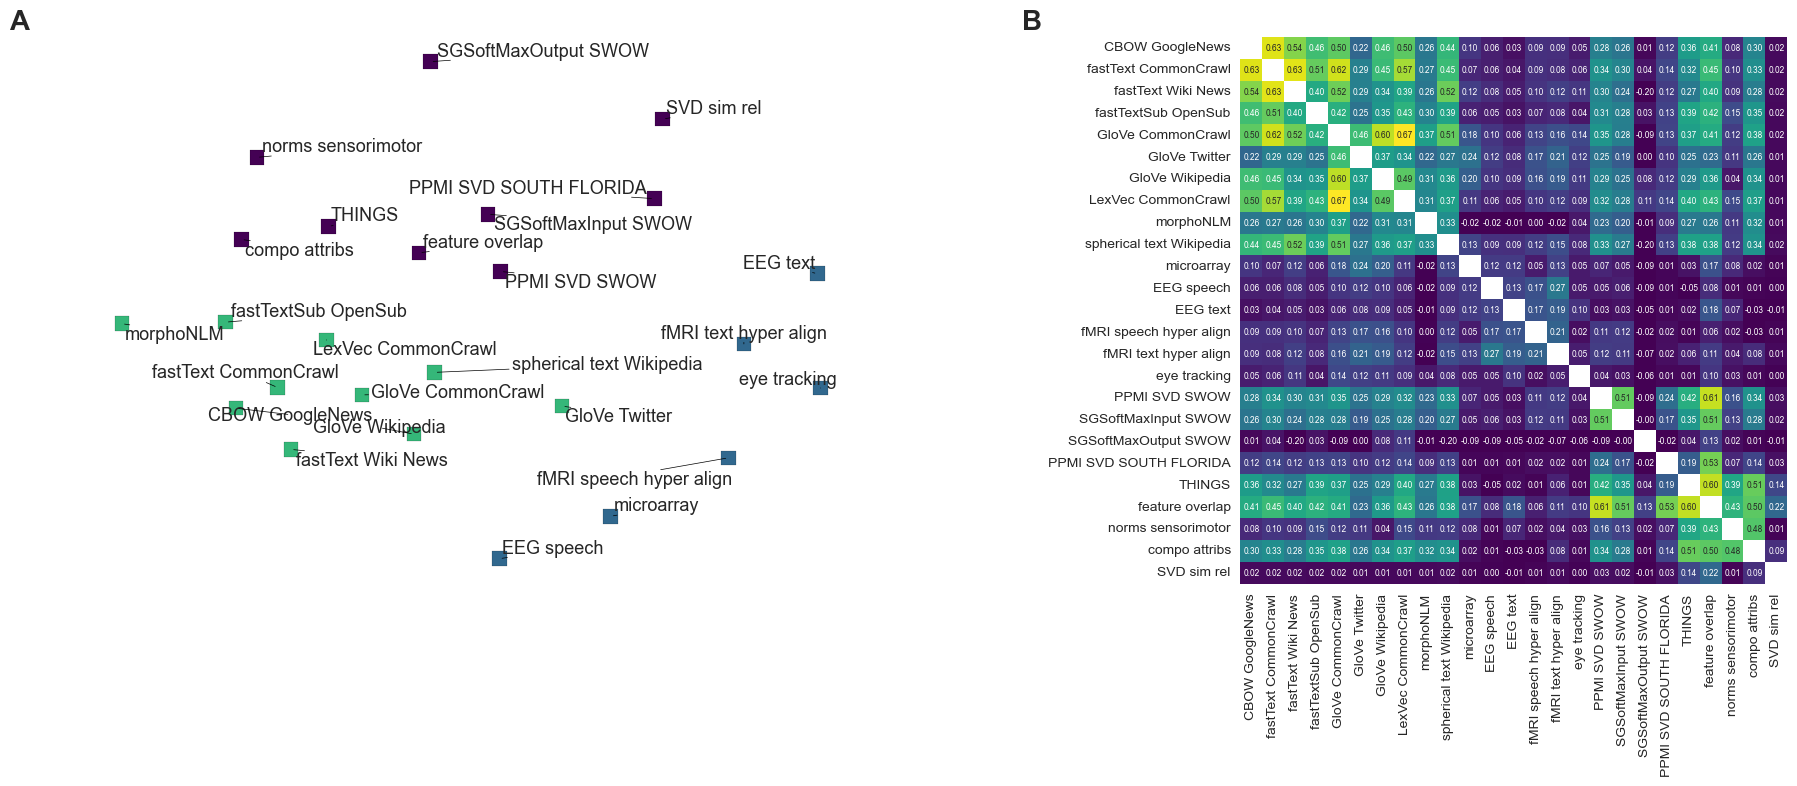

In [6]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(20, 8), width_ratios=(0.8, 1))

# MDS
cmap = plt.get_cmap('viridis', 4)
embed_type_to_color = {
    'brain': cmap(1),
    'behavior': cmap(0),
    'text': cmap(2)
}

sns.scatterplot(
    data=spearmans_2d, x=0, y=1, hue='embed_type',
    sizes=(500, 500), legend=False, s=110,
    marker='s', linewidth=0.1, edgecolor='black',
    palette=embed_type_to_color, ax=ax_1
)

ax_1.set(xticklabels='', yticklabels='', xlabel='', ylabel='')

texts = []
for model in spearmans.index:
    texts.append(
        ax_1.text(spearmans_2d[0][model], spearmans_2d[1][model], model.replace('_', ' '), fontsize=13)
    )

# Adjust text labels to avoid overlap
adjust_text(
    texts, arrowprops=dict(arrowstyle='-', color='black', lw=.5), ax=ax_1
)
ax_1.axis('off') # Turn off the axis

# Heatmap 
spearmans.index = spearmans.index.str.replace('_', ' ')
spearmans.columns = spearmans.columns.str.replace('_', ' ')
sns.heatmap(
    spearmans, square=True, annot=True, cmap='viridis',
    vmin=0, vmax=spearmans.max().max(), 
    fmt='.2f', annot_kws={"fontsize": 6}, cbar=False, ax=ax_2
)

# Adding bold panel labels
ax_1.text(-0.1, 1.05, 'A', transform=ax_1.transAxes, fontsize=20, fontweight='bold', va='top')
ax_2.text(-0.4, 1.05, 'B', transform=ax_2.transAxes, fontsize=20, fontweight='bold', va='top')

fig.tight_layout()
plt.savefig('../../figures/rsa.png', dpi=300, bbox_inches='tight')